In [158]:
# 导入所需的库
import json  # 用于读取和解析JSON格式的文件
import pandas as pd  # 用于数据处理和分析，提供DataFrame数据结构
import matplotlib.pyplot as plt  # 用于数据可视化，创建图表
import numpy as np  # 用于数值计算和数组操作
import seaborn as sns  # 基于matplotlib的数据可视化库，提供更美观的样式和高级图表
%matplotlib inline

In [159]:
# 加载实验结果文件
# 使用with语句确保文件正确关闭，'r'表示只读模式
with open('../results/logs/day1_all_experiment_results.json', 'r') as f:
    # 使用json.load()读取整个JSON文件内容并转换为Python字典
    results = json.load(f)

In [160]:
# 将嵌套的字典结构转换为扁平化的DataFrame便于分析
# 初始化空列表存储每一行数据
data = []
# 遍历results字典中的每个数据集（外层循环）
for dataset in results:
    # 遍历每个数据集中的每种方法（硬投票、软投票）
    for method in results[dataset]:
        # 获取当前数据集和方法对应的结果行
        row = results[dataset][method]
        # 将结果转换为结构化的字典并添加到data列表中
        data.append({
            'dataset': dataset,  # 数据集名称
            'method': method,  # 投票方法（hard/soft）
            'best_single_name': row['best_single']['name'],  # 最佳单模型名称
            'best_single_acc': row['best_single']['accuracy'],  # 最佳单模型准确率
            'ensemble_acc': row['ensemble_accuracy'],  # 集成模型准确率
            'weighted_acc': row['weighted_ensemble_accuracy'],  # 加权集成准确率
            'improvement_plain': row['improvement_plain'],  # 普通集成提升比例
            'improvement_weighted': row['improvement_weighted'],  # 加权集成提升比例
            'n_samples': row.get('n_samples', 'N/A'),  # 数据集样本数
            'n_features': row.get('n_features', 'N/A'),  # 数据集特征数
            'n_classes': row.get('n_classes', 'N/A')  # 数据集类别数
        })

# 将列表转换为pandas DataFrame
df = pd.DataFrame(data)

In [161]:
# 1. 数据概览
print("数据集统计:")
print("-" * 40)  # 打印分隔线

# 遍历四个数据集并打印基本信息
for dataset in ['iris', 'breast_cancer', 'wine', 'digits']:
    # 从DataFrame中筛选出当前数据集的第一行数据
    subset = df[df['dataset'] == dataset].iloc[0]
    # 打印数据集的基本信息
    print(f"{dataset}: {subset['n_samples']}样本, "
          f"{subset['n_features']}特征, "
          f"{subset['n_classes']}类别")

数据集统计:
----------------------------------------
iris: 150样本, 4特征, 3类别
breast_cancer: 569样本, 30特征, 2类别
wine: 178样本, 13特征, 3类别
digits: 1797样本, 64特征, 10类别


In [162]:
# 2. 性能对比
print("\n\n性能对比 (按数据集和方法):")
print("-" * 60)

# 创建透视表，以数据集为行，方法为列，展示不同准确率指标
pivot_table = df.pivot(index='dataset', columns='method',
                       values=['best_single_acc', 'ensemble_acc', 'weighted_acc'])
# 打印透视表，保留4位小数
print(pivot_table.round(4))



性能对比 (按数据集和方法):
------------------------------------------------------------
              best_single_acc         ensemble_acc         weighted_acc  \
method                   hard    soft         hard    soft         hard   
dataset                                                                   
breast_cancer          0.9649  0.9649       0.9649  0.9386       0.9298   
digits                 0.9917  0.9917       0.9722  0.9667       0.9861   
iris                   1.0000  1.0000       0.9667  0.9667       0.9667   
wine                   1.0000  1.0000       1.0000  1.0000       1.0000   

                       
method           soft  
dataset                
breast_cancer  0.9298  
digits         0.9861  
iris           0.9667  
wine           1.0000  


In [163]:
# 3. 提升比例分析
print("\n\n提升比例分析 (%):")
print("-" * 40)

# 创建透视表，展示不同方法的提升比例
improvement_table = df.pivot(index='dataset', columns='method',
                             values=['improvement_plain', 'improvement_weighted'])
# 打印提升比例表，保留2位小数
print(improvement_table.round(2))



提升比例分析 (%):
----------------------------------------
              improvement_plain       improvement_weighted      
method                     hard  soft                 hard  soft
dataset                                                         
breast_cancer              0.00 -2.73                -3.64 -3.64
digits                    -1.96 -2.52                -0.56 -0.56
iris                      -3.33 -3.33                -3.33 -3.33
wine                       0.00  0.00                 0.00  0.00


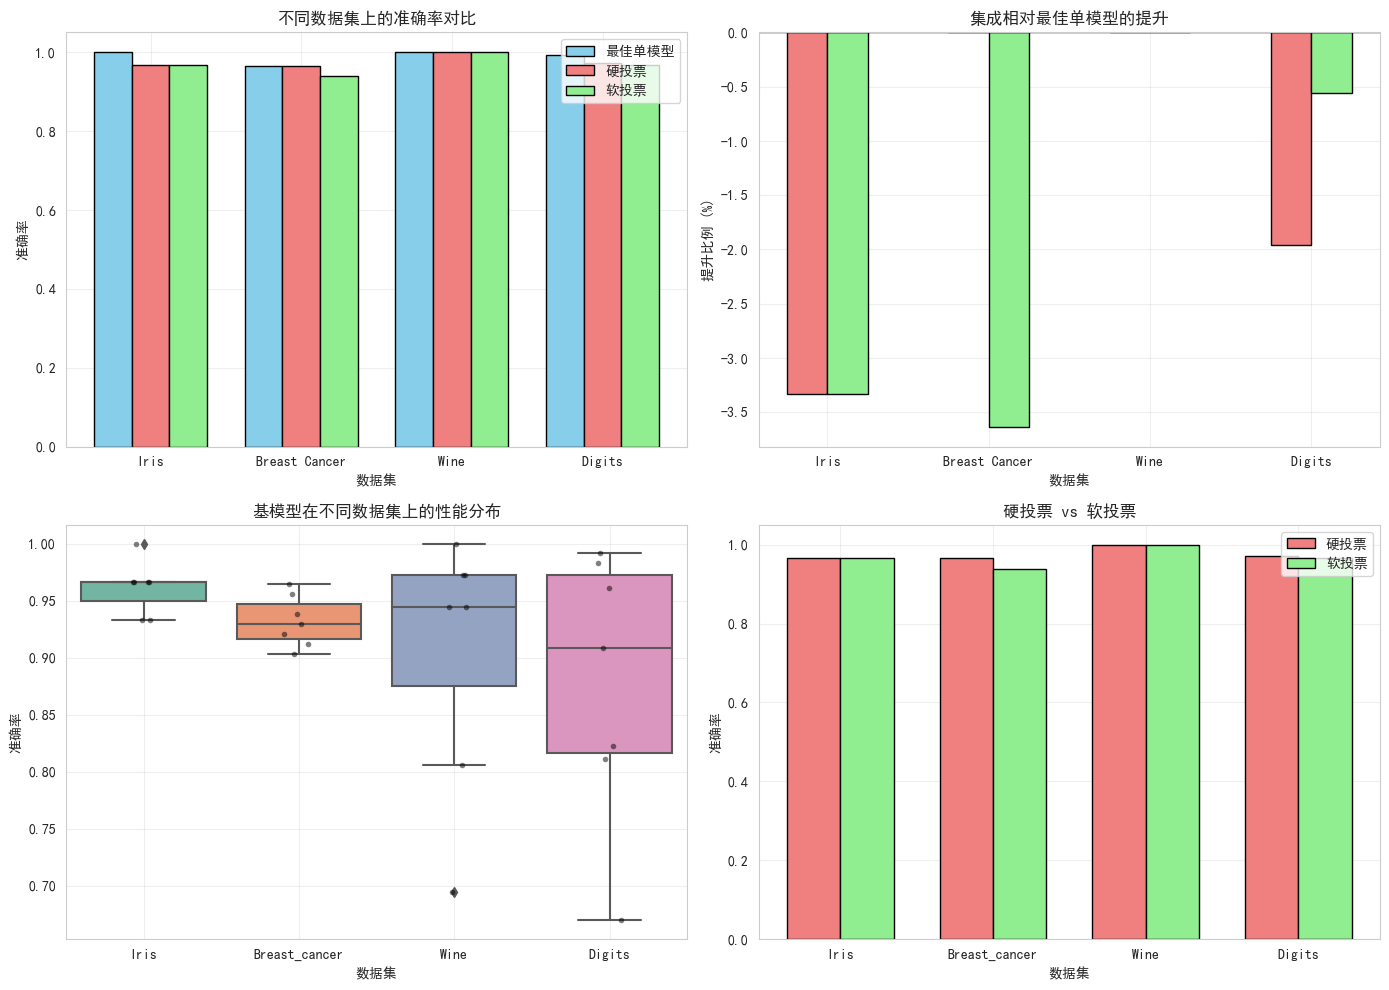

In [164]:
# 4. 可视化
# 创建2x2的子图布局，设置图形大小
fig, axes = plt.subplots(2, 2, figsize=(14, 10))


# 4.1 准确率对比
ax1 = axes[0, 0]  # 获取第一个子图

# 定义投票方法
methods = ['hard', 'soft']
# 创建x轴位置
x = np.arange(len(methods))
# 设置柱状图宽度
width = 0.25

# 遍历每个数据集
for idx, dataset in enumerate(['iris', 'breast_cancer', 'wine', 'digits']):
    # 筛选当前数据集的数据
    dataset_data = df[df['dataset'] == dataset]
    
    # 获取最佳单模型准确率
    best_acc = dataset_data['best_single_acc'].values[0]
    # 获取硬投票集成准确率
    ens_acc_hard = dataset_data[dataset_data['method'] == 'hard']['ensemble_acc'].values[0]
    # 获取软投票集成准确率
    ens_acc_soft = dataset_data[dataset_data['method'] == 'soft']['ensemble_acc'].values[0]
    
    # 绘制最佳单模型柱状图（只在第一个数据集时添加图例）
    ax1.bar(idx - width, best_acc, width, label='最佳单模型' if idx == 0 else '',
            color='skyblue', edgecolor='black')
    # 绘制硬投票柱状图
    ax1.bar(idx, ens_acc_hard, width, label='硬投票' if idx == 0 else '',
            color='lightcoral', edgecolor='black')
    # 绘制软投票柱状图
    ax1.bar(idx + width, ens_acc_soft, width, label='软投票' if idx == 0 else '',
            color='lightgreen', edgecolor='black')

# 设置x轴标签
ax1.set_xlabel('数据集')
# 设置y轴标签
ax1.set_ylabel('准确率')
# 设置图表标题
ax1.set_title('不同数据集上的准确率对比')
# 设置x轴刻度位置
ax1.set_xticks(range(4))
# 设置x轴刻度标签
ax1.set_xticklabels(['Iris', 'Breast Cancer', 'Wine', 'Digits'])
# 添加图例
ax1.legend()
# 添加网格线
ax1.grid(True, alpha=0.3)

# 4.2 提升比例
ax2 = axes[0, 1]  # 获取第二个子图

# 遍历每个数据集
for dataset in ['iris', 'breast_cancer', 'wine', 'digits']:
    # 筛选当前数据集的数据
    dataset_data = df[df['dataset'] == dataset]
    
    # 获取硬投票提升比例
    imp_hard = dataset_data[dataset_data['method'] == 'hard']['improvement_plain'].values[0]
    # 获取软投票加权提升比例
    imp_soft = dataset_data[dataset_data['method'] == 'soft']['improvement_weighted'].values[0]
    
    # 计算x轴位置
    x_pos = ['iris', 'breast_cancer', 'wine', 'digits'].index(dataset)
    # 绘制硬投票提升比例柱状图
    ax2.bar(x_pos - width / 2, imp_hard, width, color='lightcoral', edgecolor='black')
    # 绘制软投票提升比例柱状图
    ax2.bar(x_pos + width / 2, imp_soft, width, color='lightgreen', edgecolor='black')

# 添加水平参考线（y=0）
ax2.axhline(y=0, color='black', linewidth=1)
# 设置x轴标签
ax2.set_xlabel('数据集')
# 设置y轴标签
ax2.set_ylabel('提升比例 (%)')
# 设置图表标题
ax2.set_title('集成相对最佳单模型的提升')
# 设置x轴刻度位置
ax2.set_xticks(range(4))
# 设置x轴刻度标签
ax2.set_xticklabels(['Iris', 'Breast Cancer', 'Wine', 'Digits'])
# 添加网格线
ax2.grid(True, alpha=0.3)

# 4.3 模型性能分布
ax3 = axes[1, 0]  # 获取第三个子图
%matplotlib inline
# 创建一个字典来存储所有数据集的单模型结果
single_results_all = {}

# 遍历每个数据集
for dataset in ['iris', 'breast_cancer', 'wine', 'digits']:
    # 打开软投票结果文件
    with open(f'../results/logs/day1_soft_voting_results.json', 'r') as f:
        # 读取JSON文件
        soft_results = json.load(f)
        # 如果当前数据集在结果中，提取单模型结果
        if dataset in soft_results:
            single_results_all[dataset] = soft_results[dataset]['single_results']

# 转换为DataFrame便于分析
# 获取所有唯一的模型名称
model_names = set()
for dataset_results in single_results_all.values():
    model_names.update(dataset_results.keys())
# 对模型名称进行排序
model_names = sorted(model_names)

# 创建空列表存储准确率数据
accuracy_data = []
# 遍历每个数据集和每个模型
for dataset, results in single_results_all.items():
    for model in model_names:
        if model in results:
            # 添加准确率数据
            accuracy_data.append({
                'Dataset': dataset.capitalize(),  # 数据集名称首字母大写
                'Model': model,  # 模型名称
                'Accuracy': results[model]  # 模型准确率
            })

# 将数据列表转换为DataFrame
acc_df = pd.DataFrame(accuracy_data)

# 绘制箱线图展示模型性能分布
sns.boxplot(x='Dataset', y='Accuracy', data=acc_df, ax=ax3, palette='Set2')
# 添加散点图显示每个数据点
sns.stripplot(x='Dataset', y='Accuracy', data=acc_df, ax=ax3,
              color='black', alpha=0.5, jitter=True, size=4)
# 设置图表标题
ax3.set_title('基模型在不同数据集上的性能分布')
# 设置x轴标签
ax3.set_xlabel('数据集')
# 设置y轴标签
ax3.set_ylabel('准确率')
# 添加网格线
ax3.grid(True, alpha=0.3)

# 4.4 软投票 vs 硬投票
ax4 = axes[1, 1]  # 获取第四个子图

# 创建空列表存储对比数据
hard_vs_soft = []
# 遍历每个数据集
for dataset in ['iris', 'breast_cancer', 'wine', 'digits']:
    # 筛选硬投票数据
    dataset_hard = df[(df['dataset'] == dataset) & (df['method'] == 'hard')]
    # 筛选软投票数据
    dataset_soft = df[(df['dataset'] == dataset) & (df['method'] == 'soft')]
    
    # 提取硬投票准确率
    hard_acc = dataset_hard.iloc[0]['ensemble_acc']
    # 提取软投票准确率
    soft_acc = dataset_soft.iloc[0]['ensemble_acc']
    
    # 添加对比数据
    hard_vs_soft.append({
        'Dataset': dataset.capitalize(),  # 数据集名称首字母大写
        'Hard Voting': hard_acc,  # 硬投票准确率
        'Soft Voting': soft_acc  # 软投票准确率
    })

# 将对比数据转换为DataFrame
comparison_df = pd.DataFrame(hard_vs_soft)
# 创建x轴位置
x = np.arange(len(comparison_df))
# 设置柱状图宽度
width = 0.35

# 绘制硬投票柱状图
ax4.bar(x - width / 2, comparison_df['Hard Voting'], width,
        label='硬投票', color='lightcoral', edgecolor='black')
# 绘制软投票柱状图
ax4.bar(x + width / 2, comparison_df['Soft Voting'], width,
        label='软投票', color='lightgreen', edgecolor='black')

# 设置x轴标签
ax4.set_xlabel('数据集')
# 设置y轴标签
ax4.set_ylabel('准确率')
# 设置图表标题
ax4.set_title('硬投票 vs 软投票')
# 设置x轴刻度位置
ax4.set_xticks(x)
# 设置x轴刻度标签
ax4.set_xticklabels(comparison_df['Dataset'])
# 添加图例
ax4.legend()
# 添加网格线
ax4.grid(True, alpha=0.3)

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# 调整子图布局
plt.tight_layout()
# 保存图表为图片文件
plt.savefig('../results/figures/day1_detailed_analysis.png', dpi=150, bbox_inches='tight')
# 显示图表
plt.show()

In [165]:
# 5. 深度分析

# 找出集成效果最好的数据集
# 计算加权提升比例的最大值
best_improvement = df['improvement_weighted'].max()
# 找到对应的数据集
best_dataset = df.loc[df['improvement_weighted'] == best_improvement, 'dataset'].iloc[0]
print(f"1. 集成效果最好的数据集: {best_dataset} (提升{best_improvement:.2f}%)")

# 找出哪个投票方法更好
# 筛选硬投票数据并重置索引
hard_accs = df[df['method'] == 'hard'][['dataset', 'ensemble_acc']].reset_index(drop=True)
# 筛选软投票数据并重置索引
soft_accs = df[df['method'] == 'soft'][['dataset', 'ensemble_acc']].reset_index(drop=True)

# 按数据集排序确保比较的一致性
hard_accs = hard_accs.sort_values('dataset').reset_index(drop=True)
soft_accs = soft_accs.sort_values('dataset').reset_index(drop=True)

# 计算硬投票更好的数据集数量
hard_better = (hard_accs['ensemble_acc'] > soft_accs['ensemble_acc']).sum()
# 计算软投票更好的数据集数量
soft_better = (soft_accs['ensemble_acc'] > hard_accs['ensemble_acc']).sum()
print(f"2. 硬投票更好的数据集数: {hard_better}, 软投票更好的数据集数: {soft_better}")

# 分析加权优化的效果
# 计算加权集成比普通集成好的数据集数量
weighted_better = (df['weighted_acc'] > df['ensemble_acc']).sum()
print(f"3. 加权集成比普通集成好的数据集数: {weighted_better}/{len(df)}")

# 分析基模型的多样性
print("4. 基模型性能分析:")
# 遍历每个数据集
for dataset in ['iris', 'breast_cancer', 'wine', 'digits']:
    if dataset in single_results_all:
        # 获取当前数据集所有基模型的准确率
        accs = list(single_results_all[dataset].values())
        # 计算并打印统计信息
        print(f"  {dataset}: 平均准确率={np.mean(accs):.4f}, 标准差={np.std(accs):.4f}, "
              f"范围=[{min(accs):.4f}, {max(accs):.4f}]")

1. 集成效果最好的数据集: wine (提升0.00%)
2. 硬投票更好的数据集数: 2, 软投票更好的数据集数: 0
3. 加权集成比普通集成好的数据集数: 2/8
4. 基模型性能分析:
  iris: 平均准确率=0.9619, 标准差=0.0213, 范围=[0.9333, 1.0000]
  breast_cancer: 平均准确率=0.9323, 标准差=0.0208, 范围=[0.9035, 0.9649]
  wine: 平均准确率=0.9048, 标准差=0.1038, 范围=[0.6944, 1.0000]
  digits: 平均准确率=0.8782, 标准差=0.1088, 范围=[0.6694, 0.9917]
